In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV dataset
file_path = '../../data/online_retail_II.csv'
df = pd.read_csv(file_path)

# Quick preview
print(df.shape)
print(df.head())

# Basic info
df.info()

# Check missing values
print(df.isnull().sum())


(1067371, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  


           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000
Unique customers: 5942
Country
United Kingdom    1.638258e+07
EIRE              6.155196e+05
Netherlands       5.485249e+05
Germany           4.179886e+05
France            3.281918e+05
Australia         1.671291e+05
Switzerland       9.972876e+04
Spain             9.185948e+04
Sweden            8.780942e+04
Denmark           6.574109e+04
Name: TotalPrice, dtype: float64


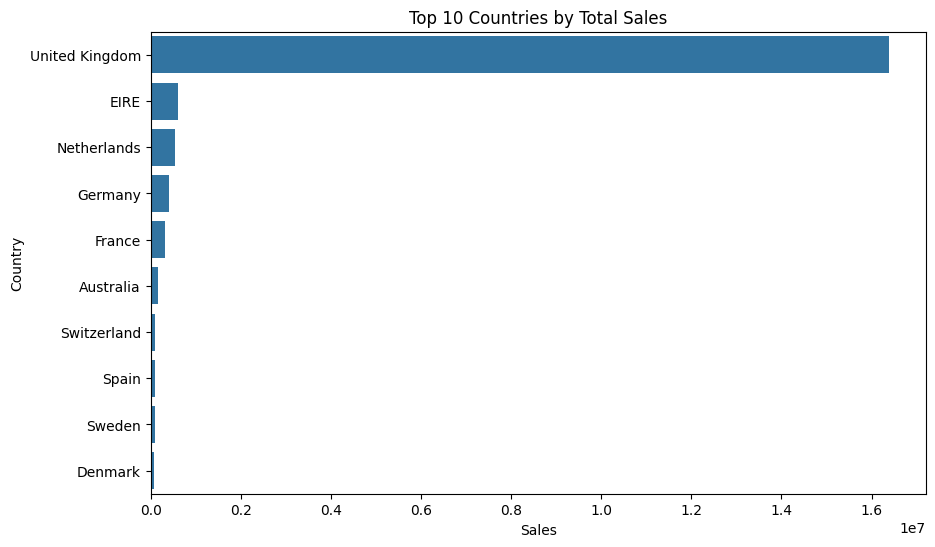

In [9]:
# Summary statistics
print(df.describe())

# Unique customers
print('Unique customers:', df['Customer ID'].nunique())

# Total sales column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Top 10 countries by sales
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print(top_countries)

# Plot sales by country
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Sales')
plt.ylabel('Country')
plt.show()


C:\Users\mz950\AppData\Local\Temp\ipykernel_28248\3551970126.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum()


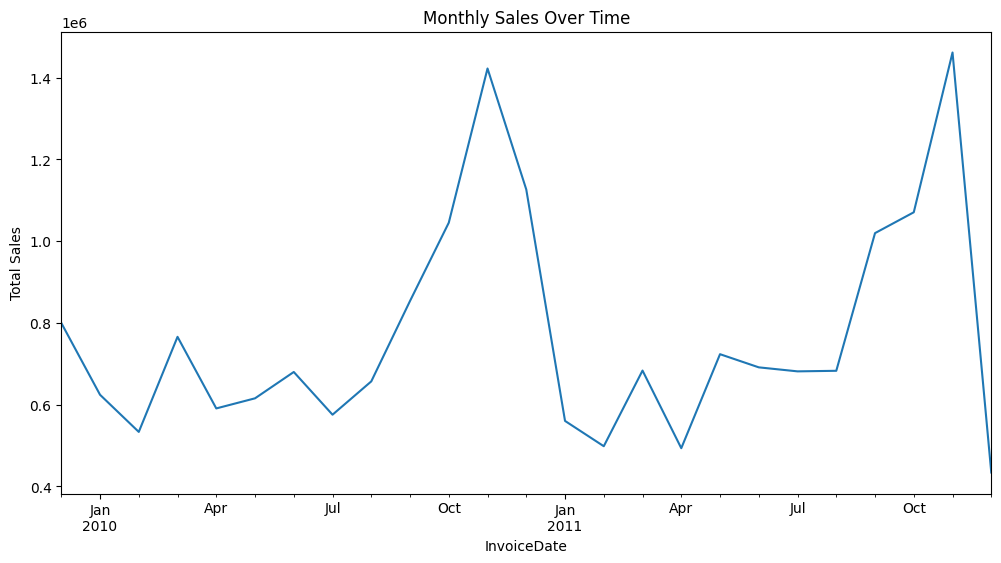

In [10]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregate monthly sales
df['TotalPrice'] = df['Quantity'] * df['Price']
monthly_sales = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['TotalPrice'].sum()

# Plot monthly sales
monthly_sales.plot(figsize=(12,6), title='Monthly Sales Over Time')
plt.ylabel('Total Sales')
plt.show()


In [12]:
import datetime as dt

# Set snapshot date as one day after the last invoice date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

print(rfm.head())


             Recency  Invoice  MonetaryValue
Customer ID                                 
12346.0          326       17         -64.68
12347.0            2        8        5633.32
12348.0           75        5        2019.40
12349.0           19        5        4404.54
12350.0          310        1         334.40


16:04:51 - cmdstanpy - INFO - Chain [1] start processing
16:04:51 - cmdstanpy - INFO - Chain [1] done processing


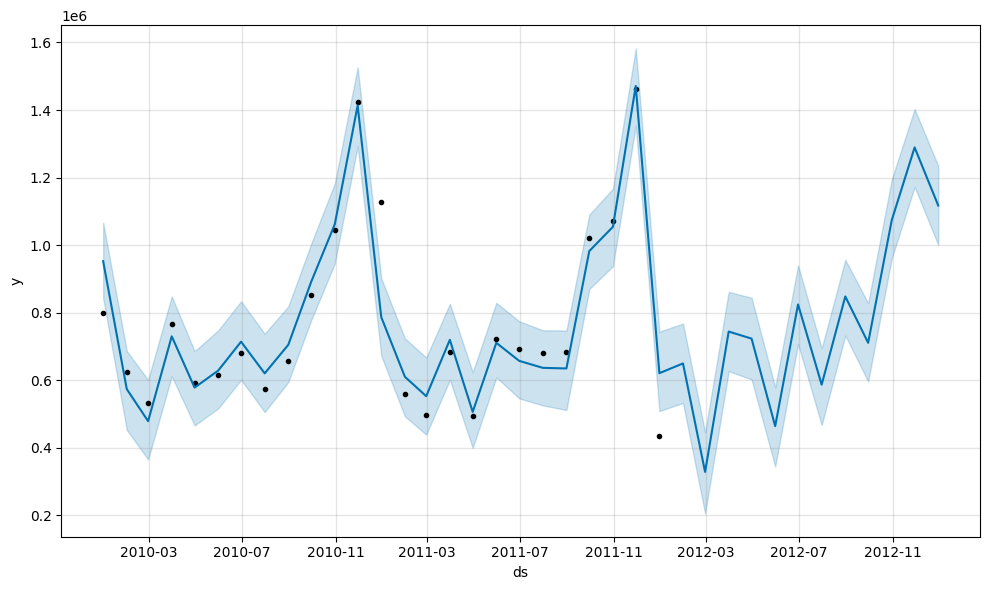

In [14]:
from prophet import Prophet

# Prepare data for Prophet
sales_df = monthly_sales.reset_index()
sales_df.columns = ['ds', 'y']  # Prophet needs these column names

# Initialize and fit model
model = Prophet()
model.fit(sales_df)

# Create future dataframe (next 12 months)
future = model.make_future_dataframe(periods=12, freq='ME')

# Forecast
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()


In [15]:
print(rfm.describe())


           Recency      Invoice  MonetaryValue
count  5942.000000  5942.000000    5942.000000
mean    202.908617     7.552339    2801.799459
std     211.857936    15.972262   13973.922553
min       1.000000     1.000000  -25111.090000
25%      25.000000     2.000000     325.097500
50%      96.000000     4.000000     843.970000
75%     381.000000     8.000000    2182.005000
max     739.000000   510.000000  598215.220000


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have:
# df with columns 'Customer ID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'Price'

# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate TotalPrice per row
df['TotalPrice'] = df['Quantity'] * df['Price']

# Define snapshot date (day after last invoice date)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

print(rfm.head())


             Recency  Frequency  MonetaryValue
Customer ID                                   
12346.0          326         17         -64.68
12347.0            2          8        5633.32
12348.0           75          5        2019.40
12349.0           19          5        4404.54
12350.0          310          1         334.40


In [18]:
# Recency: lower is better, so reverse scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency & Monetary: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], 5, labels=[1,2,3,4,5])

# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

print(rfm.head())


             Recency  Frequency  MonetaryValue R_Score F_Score M_Score  \
Customer ID                                                              
12346.0          326         17         -64.68       2       5       1   
12347.0            2          8        5633.32       5       4       5   
12348.0           75          5        2019.40       3       3       4   
12349.0           19          5        4404.54       4       3       5   
12350.0          310          1         334.40       2       1       2   

            RFM_Segment  RFM_Score  
Customer ID                         
12346.0             251          8  
12347.0             545         14  
12348.0             334         10  
12349.0             435         12  
12350.0             212          5  


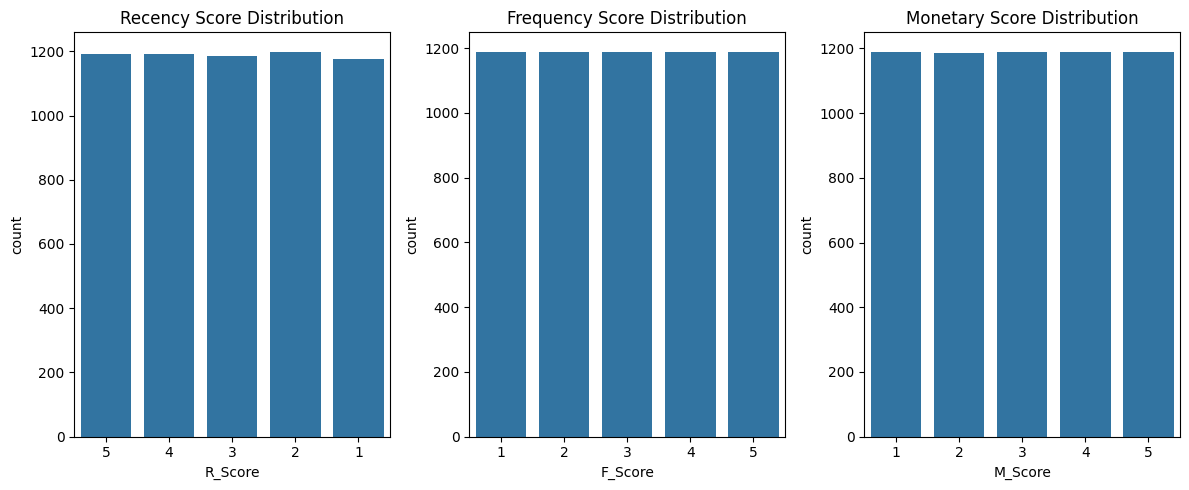

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
sns.countplot(x='R_Score', data=rfm)
plt.title('Recency Score Distribution')

plt.subplot(1,3,2)
sns.countplot(x='F_Score', data=rfm)
plt.title('Frequency Score Distribution')

plt.subplot(1,3,3)
sns.countplot(x='M_Score', data=rfm)
plt.title('Monetary Score Distribution')

plt.tight_layout()
plt.show()


In [20]:
best_customers = rfm[rfm['RFM_Score'] >= 13]  # Top 3 scores or change threshold as needed
print(f"Number of best customers: {best_customers.shape[0]}")
print(best_customers.head())


Number of best customers: 1307
             Recency  Frequency  MonetaryValue R_Score F_Score M_Score  \
Customer ID                                                              
12347.0            2          8        5633.32       5       4       5   
12352.0           36         13        1889.21       4       5       4   
12356.0           23          6        6373.68       4       4       5   
12358.0            2          5        3887.07       5       3       5   
12359.0            8         14        8714.89       5       5       5   

            RFM_Segment  RFM_Score  
Customer ID                         
12347.0             545         14  
12352.0             454         13  
12356.0             445         13  
12358.0             535         13  
12359.0             555         15  


In [21]:
rfm.to_csv('rfm_scores.csv')
